In [104]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path

import numpy as np
import torch

# dust3r_path = str(Path(os.path.join(os.getcwd())).parent / "dust3r" / "dust3r")
# sys.path.append(dust3r_path)
sys.path.append("../dust3r")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
from dust3r.image_pairs import make_pairs
from dust3r.inference import inference
from dust3r.model import AsymmetricCroCo3DStereo

In [7]:
device = "cpu"
batch_size = 1
schedule = "cosine"
lr = 0.01
niter = 300

model_name = "naver/DUSt3R_ViTLarge_BaseDecoder_512_dpt"
# you can put the path to a local checkpoint in model_name if needed
model = AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device)

In [106]:
import sys

import numpy as np
import torch

sys.path.append("..")

from src.load_images import LoadConfig, load_images

In [107]:
# images_data = load_images(["assets/Chateau1.png", "assets/Chateau2.png"], config=LoadConfig(size=512))

In [108]:
from PIL import Image

def resize_image(image_path, output_path, max_size=512):
    with Image.open(image_path) as img:
        # Calculate the new size maintaining the aspect ratio
        img.thumbnail((max_size, max_size))
        # Save the resized image
        img.save(output_path)
        
# Example usage
image_paths = ["assets/house/IMG_0251.jpeg", "assets/house/IMG_0252.jpeg", "assets/house/IMG_0253.jpeg", "assets/house/IMG_0254.jpeg"]
# resized_image_paths = [f"{Path(p).parent}/{Path(p).stem}_resized{Path(p).suffix}" for p in image_paths]
# for i, j in zip(image_paths, resized_image_paths):
#     resize_image(i, j)
images_data = load_images(image_paths, config=LoadConfig(size=512))

INFO:src.load_images:>> Loading 4 images.
INFO:src.load_images: - Added assets/house/IMG_0251.jpeg with resolution 384x512
INFO:src.load_images: - Added assets/house/IMG_0252.jpeg with resolution 384x512
INFO:src.load_images: - Added assets/house/IMG_0253.jpeg with resolution 384x512
INFO:src.load_images: - Added assets/house/IMG_0254.jpeg with resolution 384x512
INFO:src.load_images: (Successfully loaded 4 images)


In [109]:
assert list(images_data[0].__dataclass_fields__.keys()) == [
    "img_tensor",
    "true_shape",
    "idx",
    "instance",
], images_data[0].__dataclass_fields__.keys()
assert images_data[0].img_tensor.shape == torch.Size([1, 3, 384, 512]), images_data[0].img_tensor.shape
assert np.all(images_data[0].true_shape == np.array([[384, 512]]))
assert images_data[0].idx == 0
assert images_data[0].instance == "0"

assert list(images_data[1].__dataclass_fields__.keys()) == [
    "img_tensor",
    "true_shape",
    "idx",
    "instance",
], images_data[1].__dataclass_fields__.keys()
assert images_data[1].img_tensor.shape == torch.Size([1, 3, 384, 512])
assert np.all(images_data[1].true_shape == np.array([[384, 512]]))
assert images_data[1].idx == 1
assert images_data[1].instance == "1"

AssertionError: torch.Size([1, 3, 512, 384])

In [96]:
from src.make_pairs import make_pairs

In [97]:
pairs = make_pairs(images_data)

In [99]:
assert len(pairs) == 2, len(pairs)
assert pairs[0] == (images_data[1], images_data[0])
assert pairs[1] == (images_data[0], images_data[1])

AssertionError: 12

### Inference

In [100]:
from src.inference import collate_with_cat, inference, loss_of_one_batch

In [101]:
batch_size = 2
dict_pairs = [(p[0].to_dict(), p[1].to_dict()) for p in pairs]
assert len(dict_pairs) == 2

first_pair = dict_pairs[0]
assert len(first_pair) == 2  # number of images in pair should be 2

first_image_in_pair = first_pair[0]
second_image_in_pair = first_pair[1]

assert list(first_image_in_pair.keys()) == ["img", "true_shape", "idx", "instance"]
assert first_image_in_pair["idx"] == 1
assert second_image_in_pair["idx"] == 0

AssertionError: 

In [102]:
collated_dict_pairs = collate_with_cat(dict_pairs[0:batch_size])
assert len(collated_dict_pairs) == 2

first_collated_dict_pair = collated_dict_pairs[0]
assert list(first_collated_dict_pair.keys()) == ["img", "true_shape", "idx", "instance"]
assert first_collated_dict_pair["idx"] == [1, 0]
assert first_collated_dict_pair["img"].shape == torch.Size([2, 3, 384, 512])
assert torch.all(first_collated_dict_pair["true_shape"] == torch.Tensor([[384, 512], [384, 512]]))

second_collated_dict_pair = collated_dict_pairs[1]
assert list(second_collated_dict_pair.keys()) == ["img", "true_shape", "idx", "instance"]
assert second_collated_dict_pair["idx"] == [0, 1]
assert second_collated_dict_pair["img"].shape == torch.Size([2, 3, 384, 512])
assert torch.all(second_collated_dict_pair["true_shape"] == torch.Tensor([[384, 512], [384, 512]]))

AssertionError: 

In [103]:
output = loss_of_one_batch(collated_dict_pairs, model, criterion=None, device=device)


KeyboardInterrupt



In [19]:
assert list(output["view1"].keys()) == ["img", "true_shape", "idx", "instance"]
assert output["view1"]["img"].shape == torch.Size([2, 3, 384, 512])  # img1, and img0, in view1
assert torch.all(output["view1"]["true_shape"] == torch.Tensor([[384, 512], [384, 512]]))
assert np.all(output["view1"]["idx"] == np.array([1, 0]))
assert output["view1"]["instance"] == ["1", "0"]

In [20]:
assert list(output["view2"].keys()) == ["img", "true_shape", "idx", "instance"]
assert output["view2"]["img"].shape == torch.Size([2, 3, 384, 512])  # img0, and img1, in view2
assert torch.all(output["view2"]["true_shape"] == torch.Tensor([[384, 512], [384, 512]]))
assert np.all(output["view2"]["idx"] == np.array([0, 1]))
assert output["view2"]["instance"] == ["0", "1"]

In [21]:
output = inference(pairs, model, device, batch_size=batch_size)

>> Inference with model on 2 image pairs


100%|█████████████████████████████████████████████| 1/1 [00:28<00:00, 28.46s/it]


In [22]:
assert list(output.keys()) == ["view1", "view2", "pred1", "pred2", "loss"]

In [23]:
assert list(output["view1"].keys()) == ["img", "true_shape", "idx", "instance"]
assert output["view1"]["img"].shape == torch.Size([2, 3, 384, 512])
assert output["view1"]["true_shape"].shape == torch.Size([2, 2])
assert np.all(output["view1"]["idx"] == np.array([1, 0]))
assert output["view1"]["instance"] == ["1", "0"]

In [24]:
assert list(output["view2"].keys()) == ["img", "true_shape", "idx", "instance"]
assert output["view2"]["img"].shape == torch.Size([2, 3, 384, 512])
assert output["view2"]["true_shape"].shape == torch.Size([2, 2])
assert np.all(output["view2"]["idx"] == np.array([0, 1]))
assert output["view2"]["instance"] == ["0", "1"]

In [25]:
image_0_idx = images_data[0].idx
image_1_idx = images_data[1].idx
image_0_idx_for_view_1_output = output["view1"]["idx"].index(image_0_idx)
image_1_idx_for_view_1_output = output["view1"]["idx"].index(image_1_idx)
image_0_idx_for_view_2_output = output["view2"]["idx"].index(image_0_idx)
image_1_idx_for_view_2_output = output["view2"]["idx"].index(image_1_idx)
image_0_for_view_1_output = output["view1"]["img"][image_0_idx_for_view_1_output]
image_0_for_view_2_output = output["view2"]["img"][image_0_idx_for_view_2_output]
image_1_for_view_1_output = output["view1"]["img"][image_1_idx_for_view_1_output]
image_1_for_view_2_output = output["view2"]["img"][image_1_idx_for_view_2_output]

assert torch.all(image_0_for_view_1_output == image_0_for_view_2_output)
assert torch.all(image_1_for_view_1_output == image_1_for_view_2_output)

In [26]:
assert list(output["pred1"].keys()) == ["pts3d", "conf"]
assert output["pred1"]["pts3d"].shape == torch.Size([2, 384, 512, 3])  # pts3d for img1, and img0 in view1
assert output["pred1"]["conf"].shape == torch.Size([2, 384, 512])  # conf for img1, and img0 in view1

In [27]:
assert list(output["pred2"].keys()) == ["conf", "pts3d_in_other_view"]
assert output["pred2"]["pts3d_in_other_view"].shape == torch.Size(
    [2, 384, 512, 3]
)  # pts3d for img0, and img1 in view2 but in view1 coord frame
assert output["pred2"]["conf"].shape == torch.Size([2, 384, 512])  # conf for img0, and img1 in view2

In [28]:
assert output["loss"] == None

## Global Alignment

In [37]:
from src.optimizer import PointCloudOptimizer
view1, pred1 = output["view1"], output["pred1"]
view2, pred2 = output["view2"], output["pred2"]

In [39]:
# this is the relative distance computed up to a scale factor
print(torch.min(pred1['pts3d']), torch.max(pred1['pts3d']))
print(torch.min(pred2['pts3d_in_other_view']), torch.max(pred2['pts3d_in_other_view']))

tensor(-0.5133) tensor(2.5587)
tensor(-1.4339) tensor(1.8647)


In [40]:
# this is computed as conf = 1 + exp(conf_for_network_output)
print(torch.min(pred1['conf']), torch.max(pred1['conf']))
print(torch.min(pred2['conf']), torch.max(pred2['conf']))

tensor(1.) tensor(35.2004)
tensor(1.) tensor(28.4806)


In [43]:
scene = PointCloudOptimizer(view1, view2, pred1, pred2, device=device).to(device)

In [63]:
import roma
import torch.nn as nn
from src.minimum_spanning_tree import geotrf, get_med_dist_between_poses, init_minimum_spanning_tree
from src.utils import xy_grid, signed_expm1, signed_log1p

loss = scene.compute_global_alignment_v2(init="mst", niter=300, schedule=schedule, lr=lr)

 init edge (1*,0*) score=48.34430694580078
 init loss = 4.466212703846395e-05
Global alignement - optimizing for:
['pw_poses', 'pw_adaptors', 'im_poses', 'im_depthmaps', 'im_focals']


100%|████████| 300/300 [00:16<00:00, 18.17it/s, lr=1.27413e-06 loss=1.02675e-05]


In [64]:
# scene.show(viewer="gl")

KeyboardInterrupt: 

In [65]:
assert len(scene.imgs) == 2
assert scene.imgs[0].shape == (384, 512, 3)
assert len(scene.get_pts3d()) == 2
assert scene.get_pts3d()[0].shape == torch.Size([384, 512, 3])
assert len(scene.get_masks()) == 2
assert scene.get_masks()[0].shape == torch.Size([384, 512])

In [66]:
# retrieve useful values from scene:
imgs = scene.imgs
focals = scene.get_focals()
poses = scene.get_im_poses()
pts3d = scene.get_pts3d()
confidence_masks = scene.get_masks()

In [67]:
# find 2D-2D matches between the two images
from dust3r.utils.geometry import find_reciprocal_matches, xy_grid

pts2d_list, pts3d_list = [], []
for i in range(2):
    conf_i = confidence_masks[i].cpu().numpy()
    pts2d_list.append(xy_grid(*imgs[i].shape[:2][::-1])[conf_i])  # imgs[i].shape[:2] = (H, W)
    pts3d_list.append(pts3d[i].detach().cpu().numpy()[conf_i])

In [68]:
assert imgs[0].shape[:2][::-1] == (512, 384)

assert confidence_masks[0].cpu().numpy().shape == (384, 512)
assert xy_grid(*imgs[0].shape[:2][::-1]).shape == (384, 512, 2)
assert pts3d[0].detach().cpu().numpy().shape == (384, 512, 3)

# number of points selected for 2d should be the same as the mask where pixels are True
assert np.sum(confidence_masks[0].cpu().numpy()) == len(pts2d_list[0])
assert np.sum(confidence_masks[0].cpu().numpy()) == len(pts3d_list[0])

assert imgs[1].shape[:2][::-1] == (512, 384)

assert confidence_masks[1].cpu().numpy().shape == (384, 512)
assert xy_grid(*imgs[1].shape[:2][::-1]).shape == (384, 512, 2)
assert pts3d[1].detach().cpu().numpy().shape == (384, 512, 3)

# number of points selected for 2d should be the same as the mask where pixels are True
assert np.sum(confidence_masks[1].cpu().numpy()) == len(pts2d_list[1])
assert np.sum(confidence_masks[1].cpu().numpy()) == len(pts3d_list[1])

In [69]:
reciprocal_in_P2, nn2_in_P1, num_matches = find_reciprocal_matches(*pts3d_list)
print(f"found {num_matches} matches")
matches_im1 = pts2d_list[1][reciprocal_in_P2]
matches_im0 = pts2d_list[0][nn2_in_P1][reciprocal_in_P2]

found 34519 matches


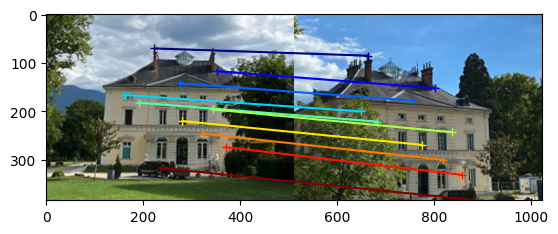

In [70]:
# visualize a few matches
import numpy as np
from matplotlib import pyplot as pl

n_viz = 10
match_idx_to_viz = np.round(np.linspace(0, num_matches - 1, n_viz)).astype(int)
viz_matches_im0, viz_matches_im1 = (
    matches_im0[match_idx_to_viz],
    matches_im1[match_idx_to_viz],
)

H0, W0, H1, W1 = *imgs[0].shape[:2], *imgs[1].shape[:2]
img0 = np.pad(imgs[0], ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), "constant", constant_values=0)
img1 = np.pad(imgs[1], ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), "constant", constant_values=0)
img = np.concatenate((img0, img1), axis=1)
pl.figure()
pl.imshow(img)
cmap = pl.get_cmap("jet")
for i in range(n_viz):
    (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
    pl.plot(
        [x0, x1 + W0],
        [y0, y1],
        "-+",
        color=cmap(i / (n_viz - 1)),
        scalex=False,
        scaley=False,
    )
pl.show(block=True)